In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
from PIL import Image
import itertools

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

2024-04-18 07:00:02.778648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 07:00:02.778800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 07:00:02.915395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules Loaded


In [3]:
# training set


data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

filepaths = []
labels = []

# Iterate over all files in the data path
for root, dirs, files in os.walk(data_path):
    for file in files:
        # Construct the file path
        fpath = os.path.join(root, file)
        filepaths.append(fpath)
        
        # Label the file based on the file path
        if 'bacteria' in fpath:
            labels.append('bacterial')
        elif 'virus' in fpath:
            labels.append('viral')
        else:
            labels.append('unknown')  # For file paths that do not contain 'bacteria' or 'virus'

# Create a DataFrame
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
df = pd.concat([FSeries, LSeries], axis=1)
df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
...,...,...
3870,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3871,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3872,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3873,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral


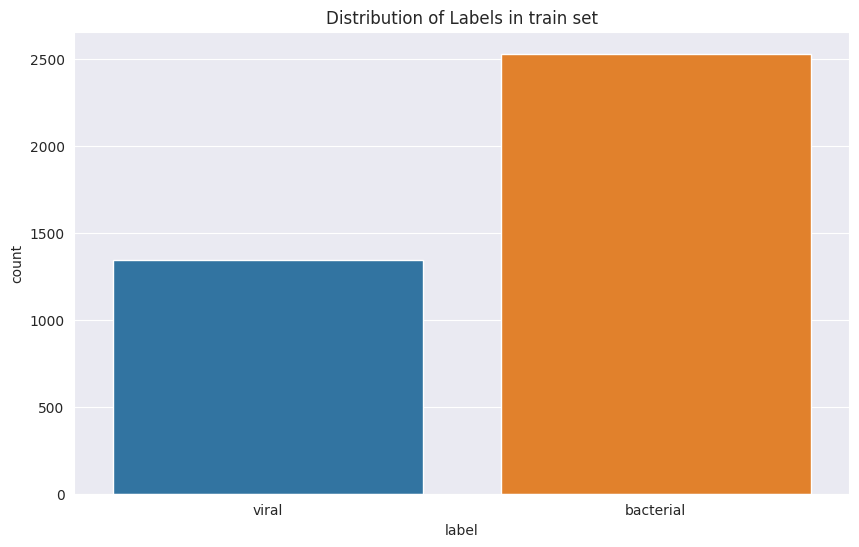

In [4]:


plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels in train set')
plt.show()


In [5]:
# training set


data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

filepaths = []
labels = []

# Iterate over all files in the data path
for root, dirs, files in os.walk(data_path):
    for file in files:
        # Construct the file path
        fpath = os.path.join(root, file)
        filepaths.append(fpath)
        
        # Label the file based on the file path
        if 'bacteria' in fpath:
            labels.append('bacterial')
        elif 'virus' in fpath:
            labels.append('viral')
        else:
            labels.append('unknown')  # For file paths that do not contain 'bacteria' or 'virus'

# Create a DataFrame
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
test_df = pd.concat([FSeries, LSeries], axis=1)
test_df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
...,...,...
385,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
386,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
387,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
388,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial


In [6]:
# training set


data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'

filepaths = []
labels = []

# Iterate over all files in the data path
for root, dirs, files in os.walk(data_path):
    for file in files:
        # Construct the file path
        fpath = os.path.join(root, file)
        filepaths.append(fpath)
        
        # Label the file based on the file path
        if 'bacteria' in fpath:
            labels.append('bacterial')
        elif 'virus' in fpath:
            labels.append('viral')
        else:
            labels.append('unknown')  # For file paths that do not contain 'bacteria' or 'virus'

# Create a DataFrame
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
val_df = pd.concat([FSeries, LSeries], axis=1)
val_df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial


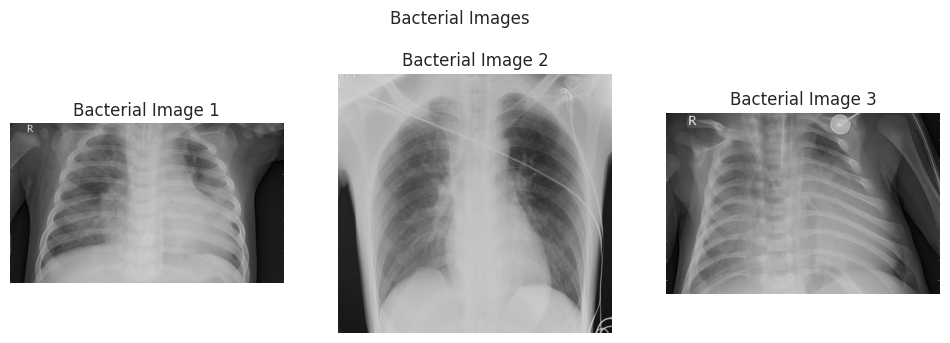

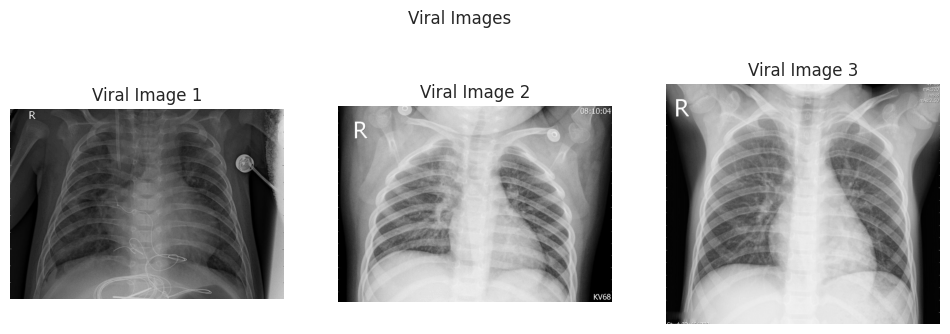

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set the data directory
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

# Get the list of bacterial and viral image paths
bacterial_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'bacteria' in f]
viral_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'virus' in f]

# Display 3 bacterial images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, path in enumerate(bacterial_paths[:3]):
    img = Image.open(path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Bacterial Image {i+1}')
    axes[i].axis('off')
plt.suptitle('Bacterial Images')
plt.show()

# Display 3 viral images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, path in enumerate(viral_paths[:3]):
    img = Image.open(path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Viral Image {i+1}')
    axes[i].axis('off')
plt.suptitle('Viral Images')
plt.show()

In [8]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=14)
valid_df, d_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=12)

batch_size = 64
img_size = (200, 200)
train_datagen = ImageDataGenerator()
val_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                              color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(dummy_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 3100 validated image filenames belonging to 2 classes.
Found 387 validated image filenames belonging to 2 classes.
Found 775 validated image filenames belonging to 2 classes.


In [9]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation

def attention_block(input_tensor, filters):
    # First convolution layer
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Attention Mechanism
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (3, 3), padding='same')(attn)
    attn = Activation('softmax')(attn)

    # Multiply the input (features) with the attention map
    output_tensor = Multiply()([input_tensor, attn])

    return output_tensor

# Define the model
input_tensor = keras.Input(shape=(200, 200, 3))
x = attention_block(input_tensor, 64)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = attention_block(x, 128)

# # another layer
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = attention_block(x, 256)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Added dense layer
x = Dense(64, activation='relu')(x)  # Added another dense layer
output_tensor = Dense(2, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_gen, validation_data=valid_gen, verbose = 1, epochs=10, batch_size=64)

# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/10


2024-04-18 07:00:29.347595: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,200,200]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,200,200]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-18 07:00:29.467640: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.45013, expected 3.69354
2024-04-18 07:00:29.467698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.89248, expected 5.1359
2024-04-18 07:00:29.467712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.13702, expected 5.38044
2024-04-18 07:00:29.467728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Di

47/49 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 0.5831 - loss: 2171.3225

2024-04-18 07:01:47.614674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.00726, expected 2.56869
2024-04-18 07:01:47.614731: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.33325, expected 2.89468
2024-04-18 07:01:47.614741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.31924, expected 2.88066
2024-04-18 07:01:47.614749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27: 3.16388, expected 2.72531
2024-04-18 07:01:47.614756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 3.24802, expected 2.80945
2024-04-18 07:01:47.614764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39: 3.16542, expected 2.72685
2024-04-18 07:01:47.614772: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 52: 3.34232, expected 2.90375
2024-04-18 07:01:47.614780: E external/local_xla/xl

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5854 - loss: 2113.1511 

2024-04-18 07:02:16.235848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.22608, expected 2.68548
2024-04-18 07:02:16.235897: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.91604, expected 3.37544
2024-04-18 07:02:16.235907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.96552, expected 3.42492
2024-04-18 07:02:16.235915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 3.74162, expected 3.20102
2024-04-18 07:02:16.235923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.20905, expected 2.66845
2024-04-18 07:02:16.235936: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18: 4.39448, expected 3.85388
2024-04-18 07:02:16.235944: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 4.31042, expected 3.76982
2024-04-18 07:02:16.235952: E external/local_xla/xla/

49/49 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5865 - loss: 2085.6572 - val_accuracy: 0.7545 - val_loss: 1.9874
Epoch 2/10


W0000 00:00:1713423739.549591      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.7555 - loss: 1.5627 - val_accuracy: 0.6848 - val_loss: 0.9579
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.8301 - loss: 0.5982 - val_accuracy: 0.7158 - val_loss: 1.1755
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.8736 - loss: 0.4155 - val_accuracy: 0.7364 - val_loss: 0.9854
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.8953 - loss: 0.3021 - val_accuracy: 0.7416 - val_loss: 0.9826
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.9242 - loss: 0.2435 - val_accuracy: 0.7390 - val_loss: 0.9793
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.9464 - loss: 0.1749 - val_accuracy: 0.7106 - val_loss: 1.1811
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 414ms/step - accuracy: 0.9581 - loss: 0.1643 - val_accuracy: 0.7054 - val_loss: 2.0901
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.9588 - loss: 0.1290 - val_accuracy: 0.710

2024-04-18 07:05:53.579893: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.87407, expected 2.88115
2024-04-18 07:05:53.579961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.07956, expected 5.08663
2024-04-18 07:05:53.579975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.93531, expected 5.94239
2024-04-18 07:05:53.579985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.60537, expected 4.61245
2024-04-18 07:05:53.579995: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.64225, expected 5.64933
2024-04-18 07:05:53.580008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.9374, expected 4.94448
2024-04-18 07:05:53.580028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.09482, expected 6.1019
2024-04-18 07:05:53.580040: E external/local_xla/xla/serv

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 853ms/step - accuracy: 0.7231 - loss: 1.3656
Test loss: 1.375069499015808, Test accuracy: 0.7109677195549011


W0000 00:00:1713423958.109277      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step


W0000 00:00:1713423963.625570      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.77       515
           1       0.56      0.64      0.60       260

    accuracy                           0.71       775
   macro avg       0.68      0.69      0.69       775
weighted avg       0.72      0.71      0.72       775



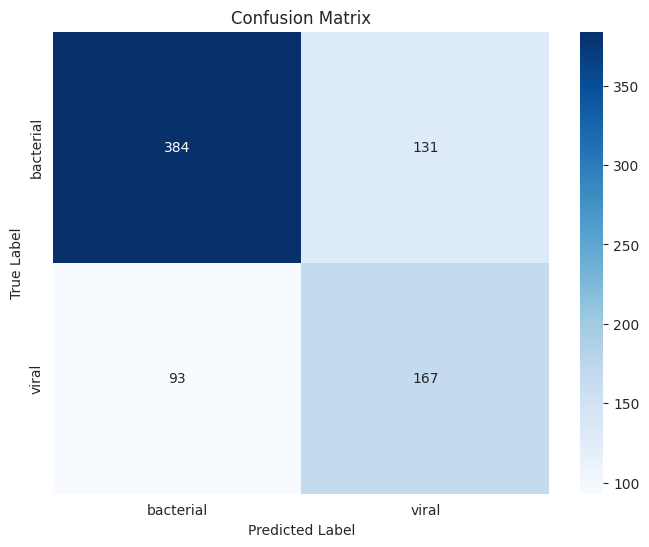

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

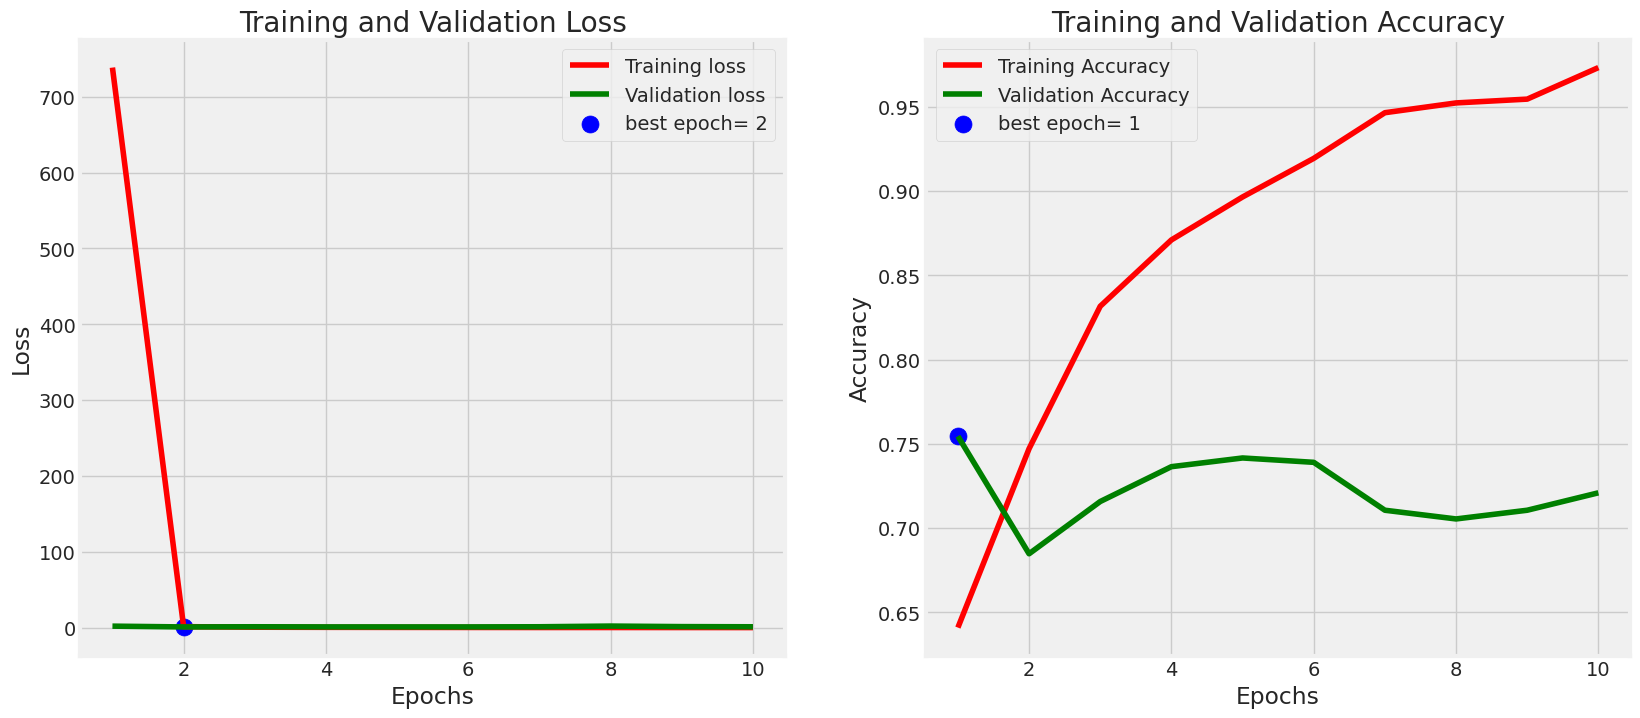

49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.9748 - loss: 0.0921
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.7146 - loss: 1.2653
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.7231 - loss: 1.3656
Train Loss:  0.085850790143013
Train Accuracy:  0.9767742156982422
--------------------
Validation Loss:  1.4071539640426636
Validation Accuracy:  0.7209302186965942
--------------------
Test Loss:  1.375069499015808
Test Accuracy:  0.7109677195549011


In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 200, 200,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 200, 200,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 200,  │          0 │ activation[0][0], │
│                     │ 64)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 200, 200,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 200,  │        577 │ activation_2[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 200, 200,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 200, 200,  │          0 │ input_layer[0][0… │
│                     │ 3)                │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 200, 200,  │      3,584 │ multiply[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 100,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 100,  │    147,584 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 100, 100,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 100,  │    147,584 │ activation_4[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 100, 100,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 100,  │          0 │ activation_4[0][

 Total params: 492,563,150 (1.83 GB)

 Trainable params: 164,187,716 (626.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 328,375,434 (1.22 GB)

In [13]:
# Save the model
model.save('/kaggle/working/Classfication_B_V_model.h5')

In [15]:

from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = model

# Define class labels
class_labels = ["bacterial", "viral"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((200, 200))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_519.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)

2024-04-18 07:10:08.350062: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.11427, expected 3.19828
2024-04-18 07:10:08.350126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.92609, expected 4.0101
2024-04-18 07:10:08.350141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.10083, expected 5.18484
2024-04-18 07:10:08.350154: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.3707, expected 3.45471
2024-04-18 07:10:08.350166: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.66646, expected 4.75047
2024-04-18 07:10:08.350176: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.03497, expected 5.11897
2024-04-18 07:10:08.350187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.50631, expected 4.59032
2024-04-18 07:10:08.350197: E external/local_xla/xla/serv

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: viral
Probability: 0.50219226
